In [242]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [243]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

In [244]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

100 100


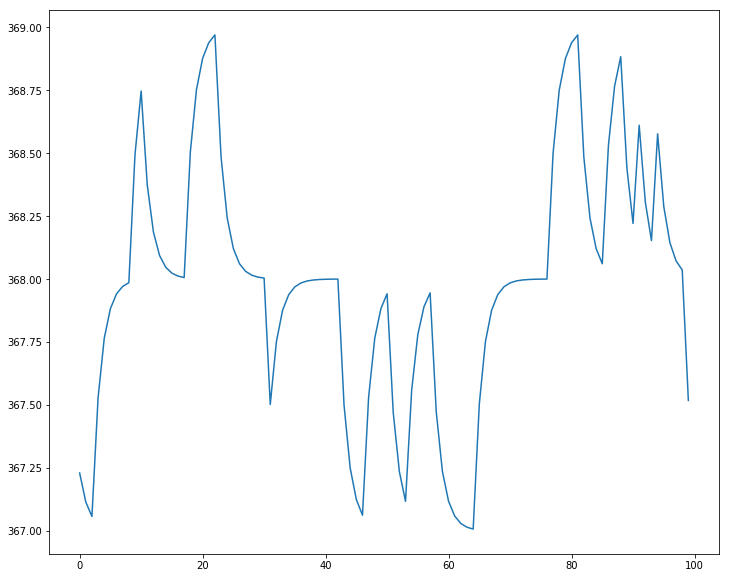

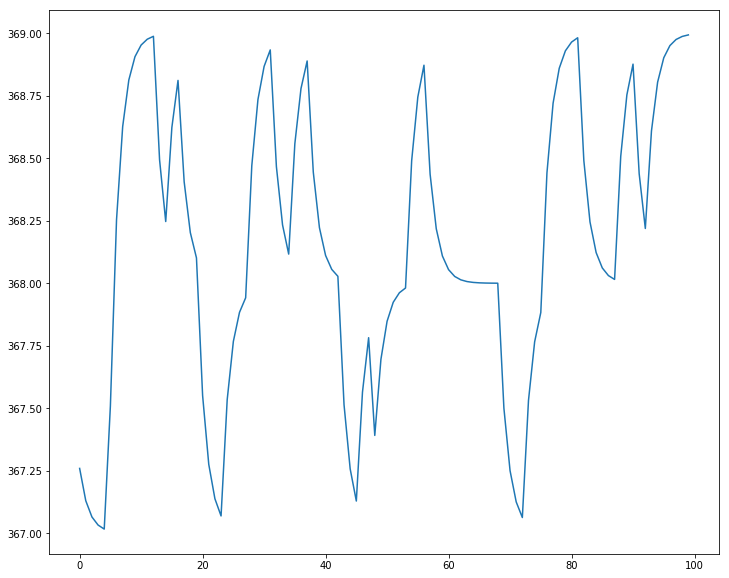

In [272]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 4000
border = 4100
num = 4200
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

Результат теста:
ADF Test Statistic : -15.600029282533058
p-value : 1.8341751240059949e-28
#Lags Used : 18
Number of Observations Used : 1980
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


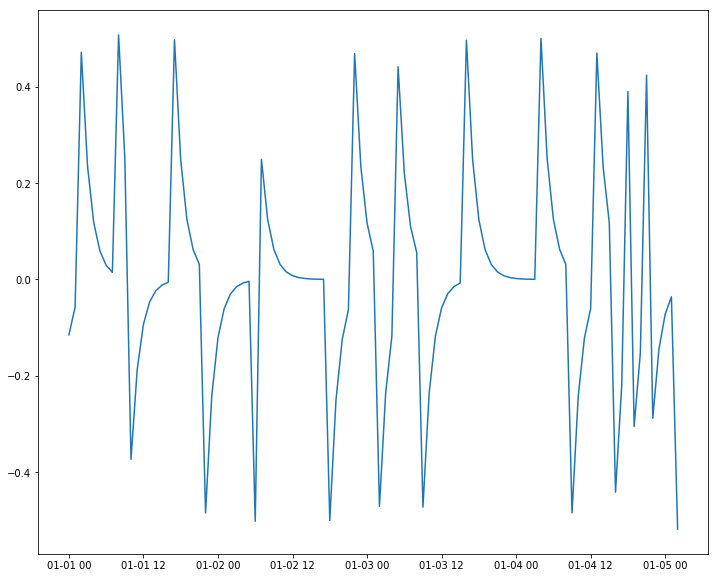

In [273]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1 = df1.diff().dropna()
while(df_test(df1_diff['flow1']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1['flow1']), freq='h')
df1_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df1_diff['flow1']), freq='h')
plt.plot(df1['flow1'])

Результат теста:
ADF Test Statistic : -6.3367288728037705
p-value : 2.8187267820925035e-08
#Lags Used : 1
Number of Observations Used : 97
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


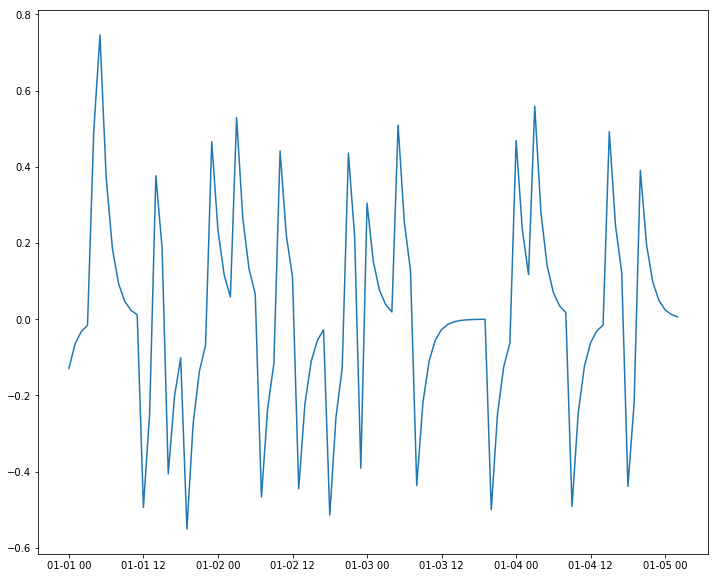

In [274]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2 = df2.diff().dropna()
while((df_test(df2['flow1']) != True) and (i in range (1, 10))):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2['flow1'])

In [331]:
model1 = SARIMAX(df1['flow1'],exog = df2["flow1"], order=(2, 1, 3), seasonal_order=(1, 0, 1, 10))
result1 = model1.fit()

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False)
forecast_values1 = pred1.predicted_mean

In [332]:
difference = np.mean(forecast_values1 - df2['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.2617821994084698 0.007234146655033974


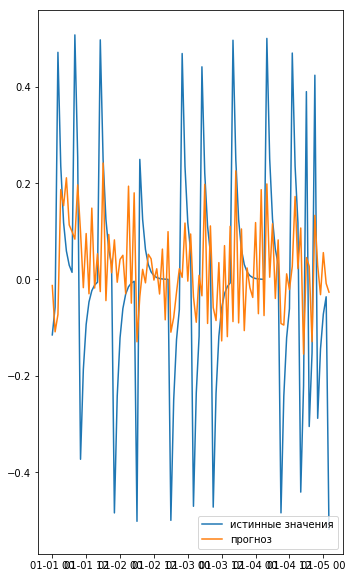

In [333]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
plt.plot(df1['flow1'])    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df1['flow1'], label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [321]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    optimal_params_arr = []
    optimal_seasonal_params_arr = []
    mse_temp = 100
    delta_temp = 10
    print("ARIMA variation")
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                non_seasonal = [i, j, k]
                try:
                    model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=non_seasonal, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                except:
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                if (forecast_mse_temp < mse_temp):
                    optimal_params_arr = [i, j, k]
                    mse_temp = forecast_mse_temp
    print(optimal_params_arr)
    print("number of seasons")
    for i in range (1, cycles):
        seasonal[3] = i
        try:
            model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=optimal_params_arr, seasonal_order=seasonal)
            result1 = model1.fit(disp = False)
        except:
            continue
        pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
        forecast_values1 = pred1.predicted_mean
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        if (forecast_mse_temp < mse_temp):
            optimal_seasonal_params_arr = [1, 1, 1, i]
            mse_temp = forecast_mse_temp
        #print(seasonal, difference, forecast_mse_temp)
    seasons_optimal = optimal_seasonal_params_arr[3]
    print(seasons_optimal)
    print("seasomal parameters")
    
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                seasonal = [i, j, k, seasons_optimal]
                try:
                    model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=optimal_params_arr, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                except:
                    print(optimal_params_arr, seasonal)
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                
                if (forecast_mse_temp < mse_temp):
                    optimal_seasonal_params_arr = seasonal
                    mse_temp = forecast_mse_temp
    return [optimal_params_arr, optimal_seasonal_params_arr, mse_temp]

In [322]:
params_non_seasonal = [1, 0, 1]
params_seasonal = [1, 0, 1, 10]
print(params_optimization(df1, df2['flow1'], params_seasonal, params_non_seasonal, 27))


ARIMA variation
[2, 1, 3]
number of seasons
20
seasomal parameters
[2, 1, 3] [1, 0, 2, 20]
[2, 1, 3] [1, 0, 3, 20]
[2, 1, 3] [1, 0, 4, 20]
[2, 1, 3] [1, 1, 1, 20]
[2, 1, 3] [1, 1, 2, 20]
[2, 1, 3] [1, 1, 3, 20]
[2, 1, 3] [1, 1, 4, 20]
[2, 1, 3] [1, 2, 1, 20]
[2, 1, 3] [1, 2, 2, 20]
[2, 1, 3] [1, 2, 3, 20]
[2, 1, 3] [1, 2, 4, 20]
[2, 1, 3] [1, 3, 1, 20]
[2, 1, 3] [1, 3, 2, 20]
[2, 1, 3] [1, 3, 3, 20]
[2, 1, 3] [1, 3, 4, 20]
[2, 1, 3] [1, 4, 1, 20]
[2, 1, 3] [1, 4, 2, 20]
[2, 1, 3] [1, 4, 3, 20]
[2, 1, 3] [1, 4, 4, 20]
[2, 1, 3] [1, 5, 1, 20]
[2, 1, 3] [1, 5, 2, 20]
[2, 1, 3] [1, 5, 3, 20]
[2, 1, 3] [1, 5, 4, 20]
[2, 1, 3] [2, 0, 2, 20]
[2, 1, 3] [2, 0, 3, 20]
[2, 1, 3] [2, 0, 4, 20]
[2, 1, 3] [2, 1, 1, 20]
[2, 1, 3] [2, 1, 2, 20]
[2, 1, 3] [2, 1, 3, 20]
[2, 1, 3] [2, 1, 4, 20]
[2, 1, 3] [2, 2, 1, 20]
[2, 1, 3] [2, 2, 2, 20]
[2, 1, 3] [2, 2, 3, 20]
[2, 1, 3] [2, 2, 4, 20]
[2, 1, 3] [2, 3, 1, 20]
[2, 1, 3] [2, 3, 2, 20]
[2, 1, 3] [2, 3, 3, 20]
[2, 1, 3] [2, 3, 4, 20]
[2, 1, 3] [2, 4, 1, 2

In [ ]:
print(params_seasonal, params_non_seasonal)